In [26]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from seaborn import boxplot
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

# added
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Experimenting LSTM model 


In [28]:
data=pd.read_csv('Data/Iowa1.csv')
data.head()

,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),Soil type,...,Sand Content %,Clay Content %,Silt Content %,soil bulk density (grams per cubic centimeter),wilting point %,field capacity %,saturation point (cm),Yield (27.6gN/m2),Yield (11.6gN/m2),Yield (40.1gN/m2)
0,1982,1,32486.40039,4,185.600006,24,-7.5,-22.0,120,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
1,1982,2,32486.40039,9,176.000000,32,-1.0,-14.0,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
2,1982,3,32486.40039,10,169.600006,40,-2.0,-14.0,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
3,1982,4,32486.40039,9,124.800003,52,-7.0,-14.5,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
4,1982,5,32486.40039,0,252.800003,52,-2.0,-16.5,160,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0


In [30]:
#Data drop for US data
data = data.drop('year',axis=1)
data = data.drop('Soil type',axis=1)
data = data.drop('swe (kg/m^2)',axis=1)
data = data.drop('Soil pH',axis=1)
data = data.drop('Yield (40.1gN/m2)',axis=1)
data = data.drop('Yield (11.6gN/m2)',axis=1)
data = data.drop(' soil bulk density (grams per cubic centimeter)',axis=1)
data = data.drop(' wilting point %',axis=1)
data = data.drop('field capacity %',axis=1)
data = data.drop('saturation point (cm)',axis=1)
data = data.drop('Soil Organic matter %',axis=1)
data = data.drop('Sand Content %',axis=1)
data = data.drop('Clay Content %',axis=1)
data = data.drop('Silt Content %',axis=1)


data.head()

,yday,dayl (s),prcp (mm/day),srad (W/m^2),tmax (deg c),tmin (deg c),vp (Pa),Yield (27.6gN/m2)
0,1,32486.40039,4,185.600006,-7.5,-22.0,120,0.0
1,2,32486.40039,9,176.000000,-1.0,-14.0,200,0.0
2,3,32486.40039,10,169.600006,-2.0,-14.0,200,0.0
3,4,32486.40039,9,124.800003,-7.0,-14.5,200,0.0
4,5,32486.40039,0,252.800003,-2.0,-16.5,160,0.0


In [32]:
x_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_data = data.values[:, :-1]
y_data = data.values[:, -1].reshape((-1, 1))
x_scaler.fit(x_data)
y_scaler.fit(y_data)
x_r_data = x_scaler.transform(x_data)
y_r_data = y_scaler.transform(y_data)

In [34]:
X_, y = x_r_data[:], y_r_data.reshape((1, -1))[0]

X_ = pd.DataFrame(X_)
y = pd.DataFrame(y)

#  select indices
num_samples = 294
random_indices = np.random.choice(len(X_), size=num_samples, replace=False)
sorted_indices = sorted(random_indices)

# Select samples using the random indices
_X_train = X_.iloc[sorted_indices]
y_train = y.iloc[sorted_indices]

# For test data, you can select the remaining indices:
test_indices = np.setdiff1d(np.arange(len(X_)), sorted_indices)
_X_test = X_.iloc[test_indices]
y_test = y.iloc[test_indices]

In [36]:
_X_train

,0,1,2,3,4,5,6
0,0.000000,0.015625,0.048193,0.242236,0.243243,0.177570,0.030769
1,0.002747,0.015625,0.108434,0.223602,0.360360,0.327103,0.061538
2,0.005495,0.015625,0.120482,0.211180,0.342342,0.327103,0.061538
3,0.008242,0.015625,0.108434,0.124224,0.252252,0.317757,0.061538
5,0.013736,0.015625,0.012048,0.304348,0.261261,0.271028,0.046154
...,...,...,...,...,...,...,...
359,0.986264,0.000000,0.000000,0.267081,0.423423,0.448598,0.123077
360,0.989011,0.000000,0.000000,0.229814,0.459459,0.514019,0.153846
362,0.994505,0.000000,0.000000,0.161491,0.270270,0.373832,0.076923
363,0.997253,0.000000,0.000000,0.298137,0.360360,0.392523,0.092308


In [38]:
_X_test

,0,1,2,3,4,5,6
4,0.010989,0.015625,0.000000,0.372671,0.342342,0.280374,0.046154
22,0.060440,0.093750,0.024096,0.503106,0.396396,0.252336,0.046154
24,0.065934,0.093750,0.036145,0.118012,0.090090,0.177570,0.030769
31,0.085165,0.140625,0.000000,0.559006,0.234234,0.102804,0.015385
34,0.093407,0.156250,0.000000,0.478261,0.099099,0.074766,0.015385
...,...,...,...,...,...,...,...
344,0.945055,0.015625,0.000000,0.360248,0.333333,0.280374,0.046154
346,0.950549,0.000000,0.000000,0.341615,0.414414,0.383178,0.092308
351,0.964286,0.000000,0.000000,0.204969,0.513514,0.579439,0.215385
354,0.972527,0.000000,0.000000,0.285714,0.441441,0.439252,0.107692


In [40]:
models = {}
models["MLP"] = MLPRegressor(solver='adam', activation='relu', max_iter=1000, learning_rate_init=0.001, hidden_layer_sizes=(1, 1, 1))

predictions = {}
colors = {"MLP":'green'} 
par_mse = []
par_rmse = []
par_rrmse = []
par_mae = []
par_r2 = []
performance_names = ["MSE", "RMSE", "RRMSE", "MAE", "R2"]
model_names = []

In [42]:
pca_model = PCA(n_components=3)
X_train = pca_model.fit_transform(_X_train)
X_test = pca_model.fit_transform(_X_test)

In [44]:
# added
lstm_model = Sequential()
inputX_train = Input(shape=(X_train.shape[1],3 ))
lstm_model.add(inputX_train)
lstm_model.add(LSTM(units=1024, return_sequences=True))#, kernel_regularizer=L1L2(l1=0.001, l2=0.001)
lstm_model.add(LSTM(units=48))#, kernel_regularizer=L1L2(l1=0.001, l2=0.001)
lstm_model.add(Dense(1))

lstm_model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Implement early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) / , callbacks=[early_stop]

lstm_model.fit(X_train.reshape(-1, 1, X_train.shape[1]), y_train, epochs=100, batch_size=30, validation_split=0.2, verbose=0)

In [45]:
lstm_predictions = lstm_model.predict(X_test.reshape(-1, 1, X_train.shape[1]))

inv_lstm_preds = y_scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).reshape((1, -1))[0]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [46]:
mse_ls = mean_squared_error(y_test, lstm_predictions)
par_mse.append(mse_ls)
rmse_ls = math.sqrt(par_mse[-1])
par_rmse.append(rmse_ls)
rrmse_ls = par_rmse[-1]/np.mean(y_test)
par_rrmse.append(rrmse_ls)
mae_ls = mean_absolute_error(y_test, lstm_predictions)
par_mae.append(mae_ls)
r2_ls = r2_score(y_test, lstm_predictions)
par_r2.append(r2_ls)
model_names.append('LSTM')
predictions['LSTM'] = lstm_predictions
colors['LSTM'] = 'purple'

In [47]:
for name in models:
    model_names.append(name)
    models[name].fit(X_train,y_train)
    y_pred = cross_val_predict(models[name], X_test, y_test,cv=3)
    predictions[name] = y_pred
    
    mse = mean_squared_error(y_test, y_pred)
    rmse =math.sqrt(mse)
    rrmse=rmse/np.mean(y_test)
    mae=mean_absolute_error(y_test, y_pred)
    r2=r2_score(y_test, y_pred)
    par_mse.append(mse)
    par_rmse.append(rmse)
    par_rrmse.append(rrmse)
    par_mae.append(mae)
    par_r2.append(r2)
    print('{:8s}'.format(name), ' =>  RMSE = {:.4f}'.format(rmse),' RRMSE = {:.4f}'.format(rrmse) ,' MAE = {:.4f}'.format(mae), ' R2 = {:.4f}'.format(r2)) #MSE = {:.4f}'.format(mse)

print('LSTM', ' =>  RMSE = {:.4f}'.format(rmse_ls),' RRMSE = {:.4f}'.format(rrmse_ls) ,' MAE = {:.4f}'.format(mae_ls), ' R2 = {:.4f}'.format(r2_ls)) 

H:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
H:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP       =>  RMSE = 0.4584  RRMSE = 3.5117  MAE = 0.3885  R2 = -1.5728
LSTM  =>  RMSE = 0.1609  RRMSE = 1.2324  MAE = 0.0670  R2 = 0.6831


H:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
H:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
H:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


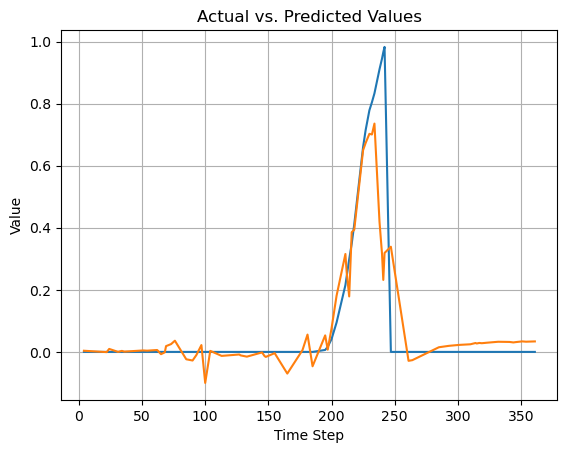

In [48]:
plt.plot(y_test.assign(LSTM=predictions['LSTM']))
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()

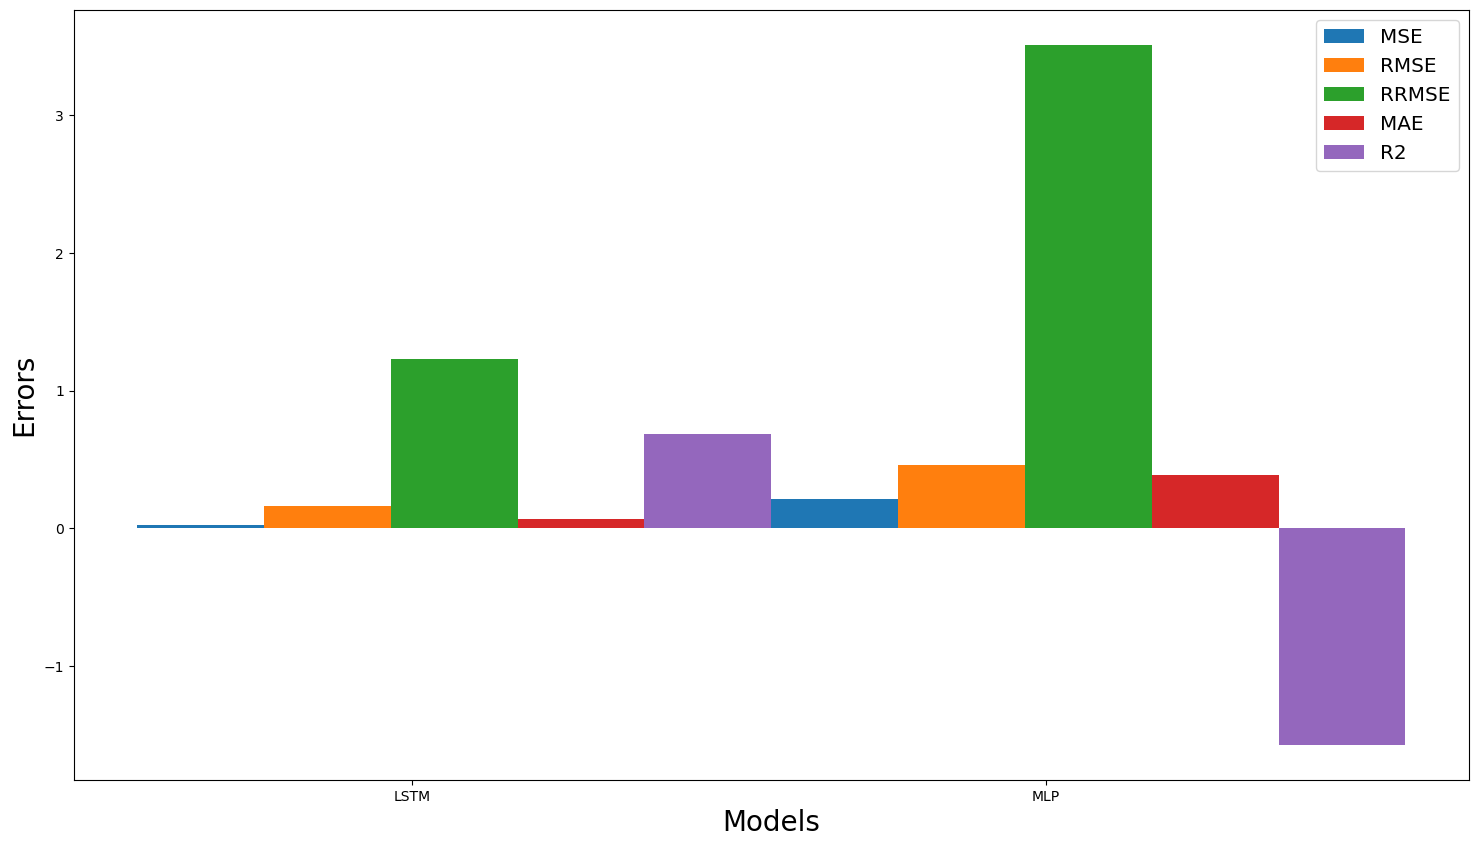

In [49]:
X_axis = np.arange(len(model_names))
plt.figure(figsize=(18, 10))
width = 0.2
r_width = 0
par = [par_mse, par_rmse, par_rrmse,par_mae, par_r2] 
for i, name in enumerate(performance_names):
    plt.bar(X_axis + r_width, par[i], width=width, label = name)
    r_width +=width
  
plt.xticks(X_axis+r_width/3, model_names)
plt.xlabel("Models", fontsize=20)
plt.ylabel("Errors", fontsize=20)
plt.legend(fontsize="x-large")
plt.show()